In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
import scipy.cluster.hierarchy as sch
from sklearn import metrics
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
pop = pd.read_csv("Population_2000_2018.csv")
dispo_ali = pd.read_csv("DisponibiliteAlimentaire_2017.csv")

Préparation des données, nettoyage, fusion etc.

In [2]:
# on vérifie les données;
pop.describe()


,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,4411.000000,4411.0,4411.0,4411.000000,4411.000000,4.411000e+03
mean,132.202902,511.0,3010.0,2009.068238,2009.068238,2.963004e+04
std,75.854840,0.0,0.0,5.481539,5.481539,1.238029e+05
min,1.000000,511.0,3010.0,2000.000000,2000.000000,7.850000e-01
25%,68.000000,511.0,3010.0,2004.000000,2004.000000,3.921890e+02
50%,132.000000,511.0,3010.0,2009.000000,2009.000000,4.764741e+03
75%,195.000000,511.0,3010.0,2014.000000,2014.000000,1.821548e+04
max,299.000000,511.0,3010.0,2018.000000,2018.000000,1.427648e+06


In [3]:
pop.isnull().sum()

Code Domaine                 0
Domaine                      0
Code zone                    0
Zone                         0
Code Élément                 0
Élément                      0
Code Produit                 0
Produit                      0
Code année                   0
Année                        0
Unité                        0
Valeur                       0
Symbole                      0
Description du Symbole       0
Note                      4153
dtype: int64

In [4]:
dispo_ali.describe()

,Code zone,Code Élément,Code Produit,Code année,Année,Valeur
count,176600.000000,176600.000000,176600.000000,176600.0,176600.0,176600.000000
mean,125.474740,3810.052894,2628.778545,2017.0,2017.0,210.554918
std,72.941699,2211.790089,91.993247,0.0,0.0,4762.047787
min,1.000000,645.000000,2511.000000,2017.0,2017.0,-10388.000000
25%,63.000000,684.000000,2556.000000,2017.0,2017.0,0.000000
50%,120.000000,5142.000000,2612.000000,2017.0,2017.0,0.120000
75%,188.000000,5301.000000,2732.000000,2017.0,2017.0,8.462500
max,276.000000,5911.000000,2899.000000,2017.0,2017.0,758548.000000


In [5]:
dispo_ali.isnull().sum()

Code Domaine              0
Domaine                   0
Code zone                 0
Zone                      0
Code Élément              0
Élément                   0
Code Produit              0
Produit                   0
Code année                0
Année                     0
Unité                     0
Valeur                    0
Symbole                   0
Description du Symbole    0
dtype: int64

In [6]:
# On garde les données qui nous intéresse;
dispo_ali = dispo_ali[["Zone","Code zone", "Élément","Code Élément", "Produit","Code Produit", "Année", "Unité","Valeur"]]
pop = pop[["Zone","Code zone", "Produit", "Année", "Valeur" ]]
# on créer notre fusion
tableau = pd.merge(dispo_ali, pop, on= ["Année", "Code zone"])
tableau.head()

,Zone_x,Code zone,Élément,Code Élément,Produit_x,Code Produit,Année,Unité,Valeur_x,Zone_y,Produit_y,Valeur_y
0,Afghanistan,2,Production,5511,Blé et produits,2511,2017,Milliers de tonnes,4281.0,Afghanistan,Population-Estimations,36296.113
1,Afghanistan,2,Importations - Quantité,5611,Blé et produits,2511,2017,Milliers de tonnes,2302.0,Afghanistan,Population-Estimations,36296.113
2,Afghanistan,2,Variation de stock,5072,Blé et produits,2511,2017,Milliers de tonnes,-119.0,Afghanistan,Population-Estimations,36296.113
3,Afghanistan,2,Exportations - Quantité,5911,Blé et produits,2511,2017,Milliers de tonnes,0.0,Afghanistan,Population-Estimations,36296.113
4,Afghanistan,2,Disponibilité intérieure,5301,Blé et produits,2511,2017,Milliers de tonnes,6701.0,Afghanistan,Population-Estimations,36296.113


In [7]:
# on supprime les données inutiles et on renomme; 
del tableau["Produit_y"]
del tableau["Zone_y"]
tableau.columns = ["Zone","Code zone", "Elément","Code élément", "Produit","Code produit", "Année", "Unité", "Valeur", "Population"]
# On filtre sur les volailles et on met au bonne unité; 
tableau = tableau[tableau.Produit.eq("Viande de Volailles")]
tableau["Valeur"] = tableau["Valeur"] * 1000
pd.options.display.float_format = '{:20,.2f}'.format
del tableau["Unité"]
# on supprime et renome les données et on index les éléments pour pouvoir garder ceux qui nous interesses; 
data_clus = tableau.drop(columns=["Code élément", "Produit","Code produit", "Année", "Code zone"])
data_clus = data_clus.set_index("Elément")
data_clus = data_clus.drop(["Semences", "Traitement", "Résidus", "Variation de stock", "Aliments pour animaux" , "Alimentation pour touristes", "Autres utilisations (non alimentaire)"])
data_clus

,Zone,Valeur,Population
Elément,,,
Production,Afghanistan,"28,000.00","36,296.11"
Importations - Quantité,Afghanistan,"29,000.00","36,296.11"
Disponibilité intérieure,Afghanistan,"57,000.00","36,296.11"
Pertes,Afghanistan,"2,000.00","36,296.11"
Nourriture,Afghanistan,"55,000.00","36,296.11"
...,...,...,...
Nourriture,Zimbabwe,"67,000.00","14,236.59"
Disponibilité alimentaire en quantité (kg/personne/an),Zimbabwe,"4,680.00","14,236.59"
Disponibilité alimentaire (Kcal/personne/jour),Zimbabwe,"16,000.00","14,236.59"


In [8]:
# on crée un pivot table pour avoir les élément en colonne et on remplace les valeur NaN en 0;
data_clus_pivot = pd.pivot_table(data_clus, index= 'Zone', columns= "Elément", values='Valeur')
data_clus_pivot.columns = ["Dispo_calo", "Dispo_ali_quanti", "Dispo_matiere_grasse", "Dispo_prot", "Dispo_int", "Export", "Import", "Nourriture", "Pertes", "Produc"]
data_clus_pivot = data_clus_pivot[[ "Dispo_int", "Export", "Import", "Nourriture", "Produc"]]
data_clus_pivot = data_clus_pivot.fillna(0)
data_final = data_clus_pivot
data_final

,Dispo_int,Export,Import,Nourriture,Produc
Zone,,,,,
Afghanistan,"57,000.00",0.00,"29,000.00","55,000.00","28,000.00"
Afrique du Sud,"2,118,000.00","63,000.00","514,000.00","2,035,000.00","1,667,000.00"
Albanie,"47,000.00",0.00,"38,000.00","47,000.00","13,000.00"
Algérie,"277,000.00",0.00,"2,000.00","264,000.00","275,000.00"
Allemagne,"1,739,000.00","646,000.00","842,000.00","1,609,000.00","1,514,000.00"
...,...,...,...,...,...
Émirats arabes unis,"412,000.00","94,000.00","433,000.00","412,000.00","48,000.00"
Équateur,"341,000.00",0.00,0.00,"324,000.00","340,000.00"
États-Unis d'Amérique,"18,266,000.00","3,692,000.00","123,000.00","18,100,000.00","21,914,000.00"


On vérifie la norme de nos données et on normalise si nécessaire

In [9]:
# on regarde les moyennes et écart type; 
moyenne = data_final.mean(axis= 0)
ecart = data_final.std(axis= 0)
moyenne, ecart

(Dispo_int              679,598.84
 Export                 103,750.00
 Import                  88,488.37
 Nourriture             649,406.98
 Produc                 708,325.58
 dtype: float64,
 Dispo_int            2,175,612.99
 Export                 458,066.12
 Import                 185,824.62
 Nourriture           2,125,189.09
 Produc               2,474,456.33
 dtype: float64)

In [10]:
# normalisation; 

data_norm = (data_final - moyenne)/ecart
data_norm

,Dispo_int,Export,Import,Nourriture,Produc
Zone,,,,,
Afghanistan,-0.29,-0.23,-0.32,-0.28,-0.27
Afrique du Sud,0.66,-0.09,2.29,0.65,0.39
Albanie,-0.29,-0.23,-0.27,-0.28,-0.28
Algérie,-0.19,-0.23,-0.47,-0.18,-0.18
Allemagne,0.49,1.18,4.05,0.45,0.33
...,...,...,...,...,...
Émirats arabes unis,-0.12,-0.02,1.85,-0.11,-0.27
Équateur,-0.16,-0.23,-0.48,-0.15,-0.15
États-Unis d'Amérique,8.08,7.83,0.19,8.21,8.57


In [11]:
# verif moyenne par colonne = 0 et verif ecart = 1
data_norm.mean(axis=0), data_norm.std(axis=0)

(Dispo_int                   -0.00
 Export                      -0.00
 Import                       0.00
 Nourriture                   0.00
 Produc                      -0.00
 dtype: float64,
 Dispo_int                    1.00
 Export                       1.00
 Import                       1.00
 Nourriture                   1.00
 Produc                       1.00
 dtype: float64)

ACP

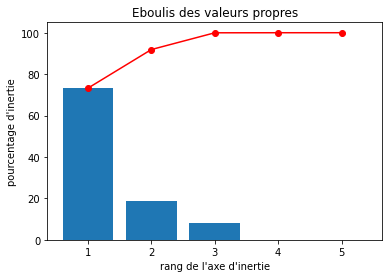

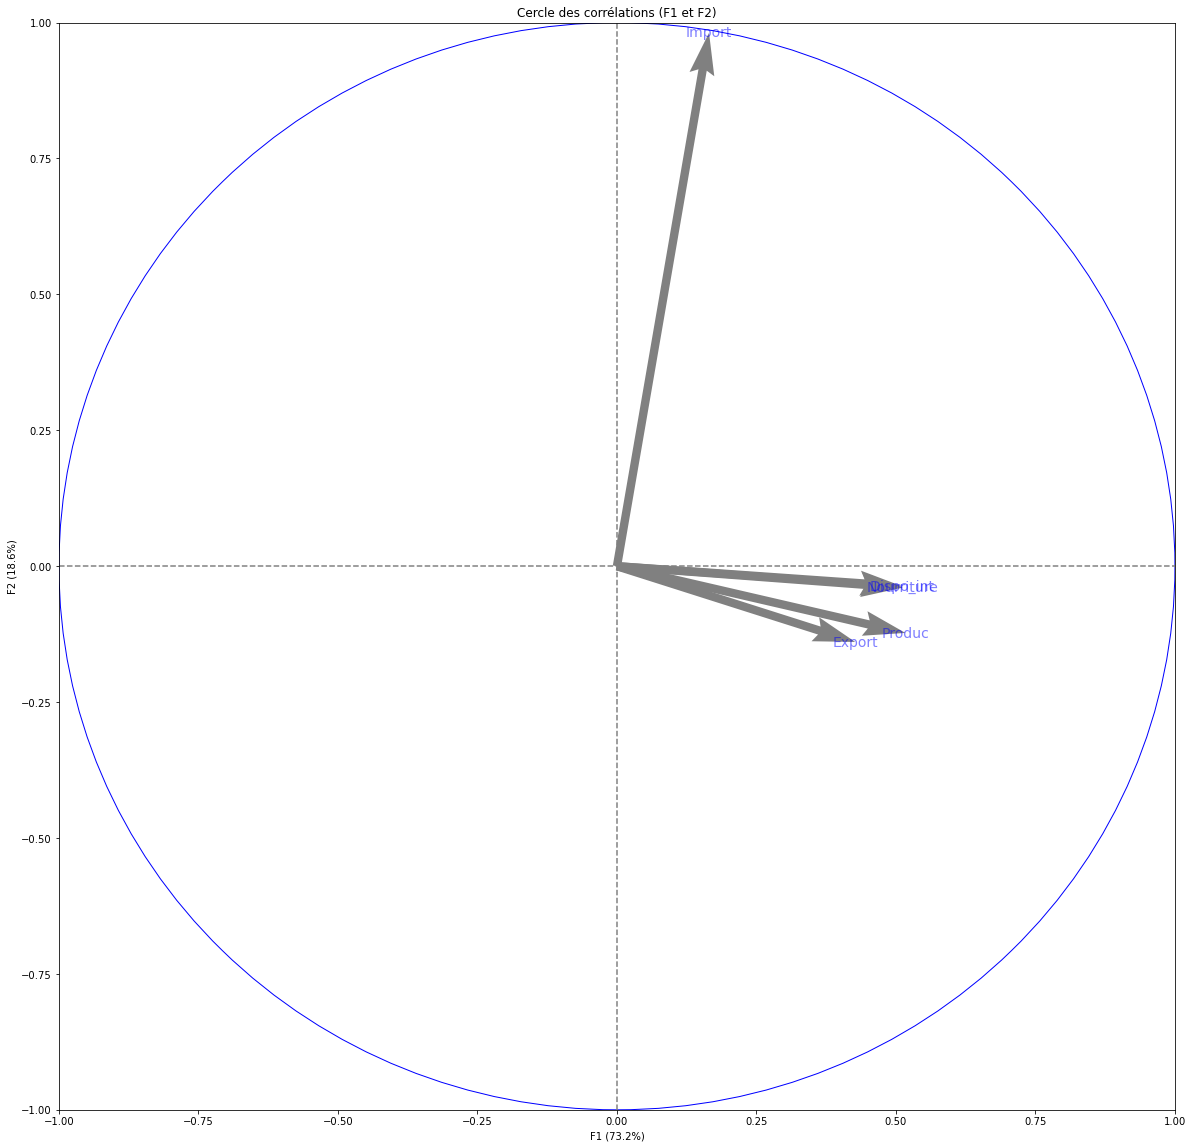

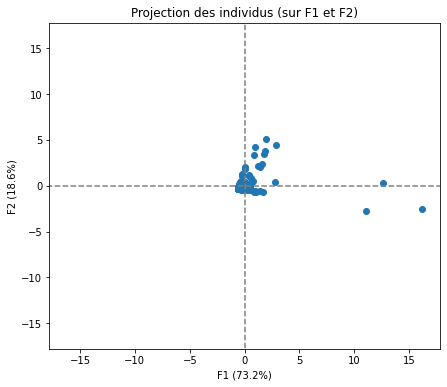

In [12]:
features = data_norm.columns
#centrage et reduction des données;
X_scaled = preprocessing.StandardScaler().fit_transform(data_norm.values)
# Calcul des composantes principales
pca = decomposition.PCA(n_components=5)
X_projected = pca.fit_transform(X_scaled)
# Eboulis des valeurs propres
display_scree_plot(pca)
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 5, pca, [(0,1)], labels = np.array(features))
display_factorial_planes(X_projected, 5, pca, [(0,1)])
plt.show()

Nous voyons ici que les variables Dispo interieur, production et nourriture sont fortement corrélée à F1 et que Ratio import et import eux sont corrélée à F2.
Nous pouvons donc classer F1 comme étant la production 
Et F2 comme etant les besoin extérieur du pays. 

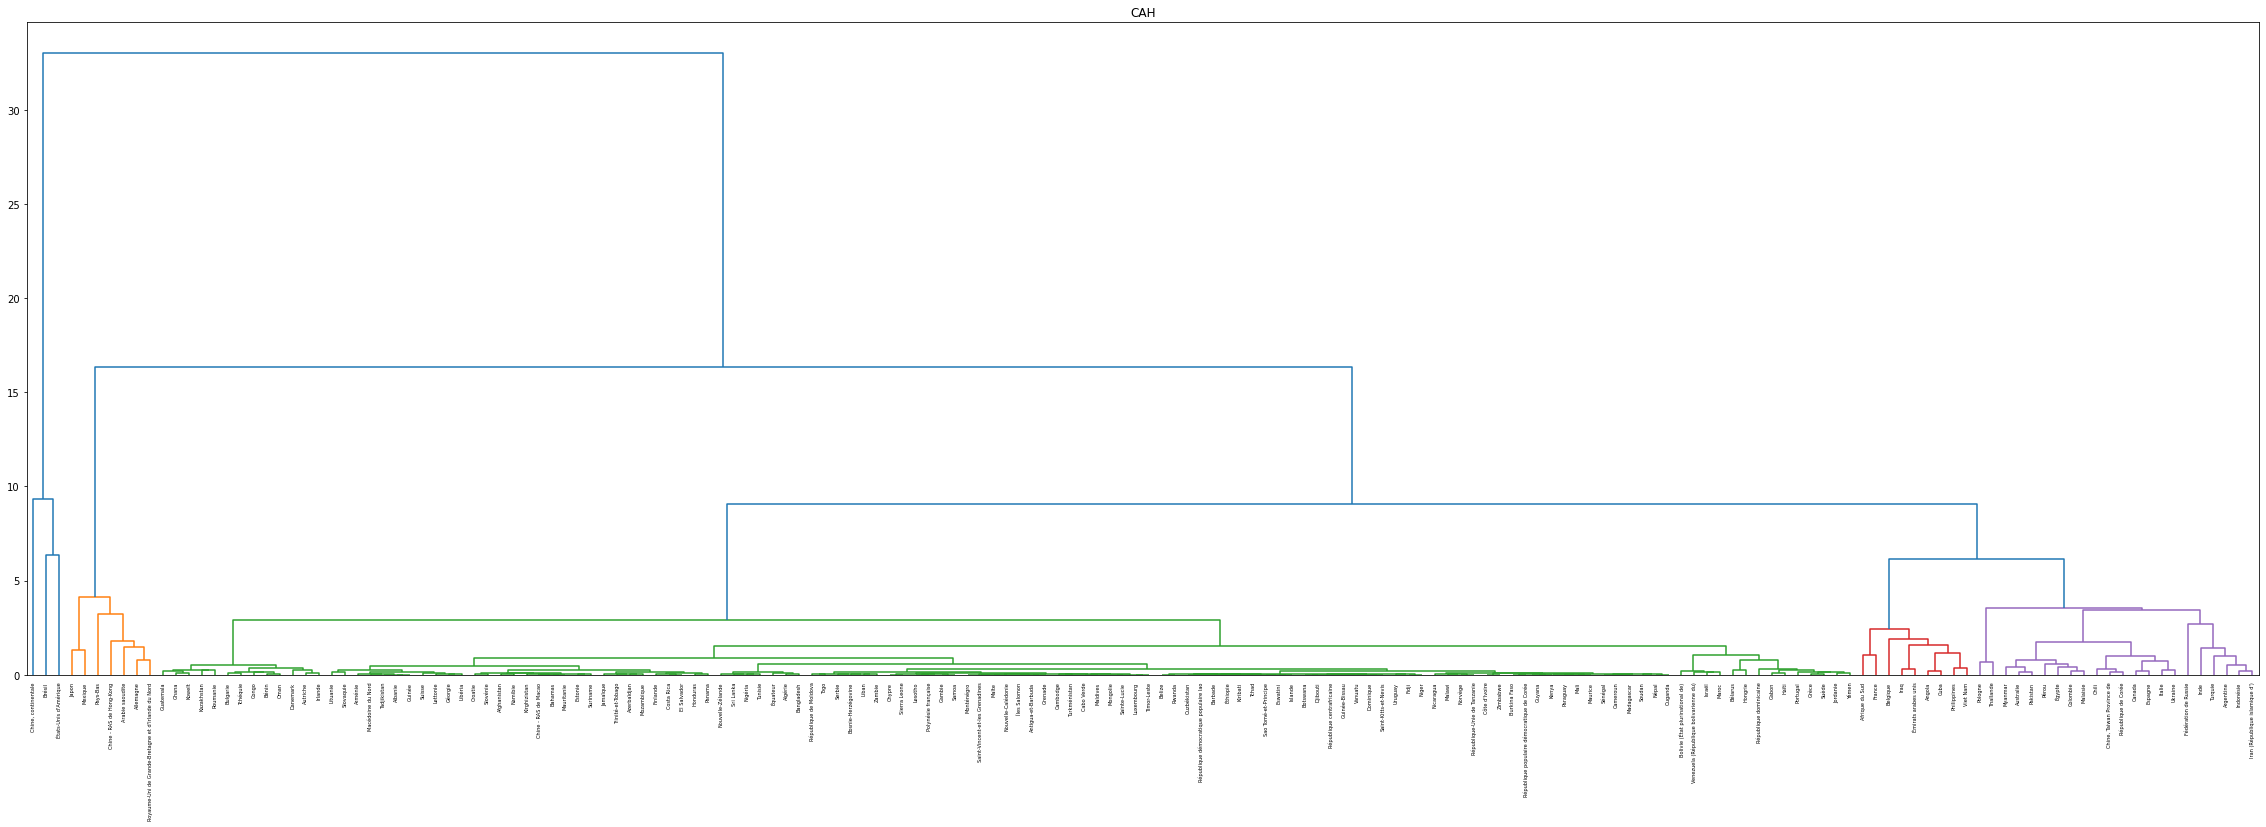

,Dispo_int,Export,Import,Nourriture,Produc
index,,,,,
1,"15,469,666.67","2,830,333.33","192,666.67","15,200,000.00","18,117,000.00"
2,"1,813,428.57","445,000.00","842,714.29","1,761,285.71","1,504,571.43"
3,"356,716.05","38,512.35","53,969.14","331,907.41","351,537.04"


In [13]:
#générer la matrice des liens 
Z = linkage(data_norm,method='ward') 
plt.figure(figsize=(40,12))
plt.title("CAH") 
dendrogram(Z,labels=data_norm.index,color_threshold=5)
plt.show()
#découpage à la hauteur t = 7 ==> identifiants de 4 groupes obtenus
groupes_cah = fcluster(Z,t=10,criterion='distance')
#affichage des observations et leurs groupes
import numpy as np
idg = np.argsort(groupes_cah)
classe = pd.DataFrame(data_norm.index[idg],groupes_cah[idg]).reset_index()
data_final.reset_index()
classe = pd.merge(data_final, classe, on = "Zone" )
classe.groupby(["index"]).mean()


Nous voyons donc ici par l'utilisation d'une classification hierarchique les differents pays qui ont pu resortir.
Ici nous voyons ici une découpe en 3 classes que l'on peut interpreter comme étant:  
La première classe les pays les plus producteur et exportateur ( peut être moins interessant pour nous)
La seconde classe les pays les importateur ( avec une forte demande de nourriture, peut être les pays a garder.)
La troisièmes classe les pays ou les données sont moins forte peut etre plus petit pays et ou moins interessant pour nôtre étude. 

Méthode de clustering avec les kmeans.

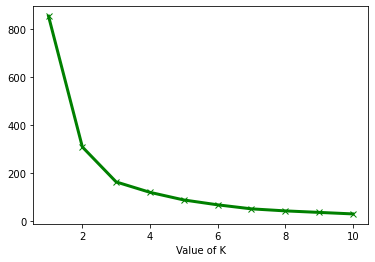

In [14]:
# Méthode Elbow 
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(data_norm) 
    cost.append(KM.inertia_)      
plt.plot(range(1, 11), cost, color ='g', linewidth ='3',marker="x") 
plt.xlabel("Value of K") 
plt.show() 

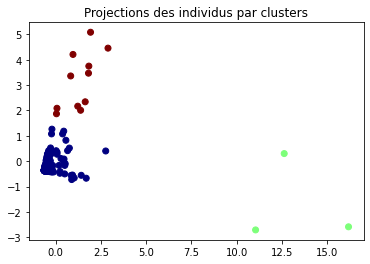

In [15]:
kmeans = KMeans(n_clusters= 3)
kmeans.fit(data_norm.values)
data_norm["Clusters"] = kmeans.labels_
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data_norm["Clusters"], cmap = 'jet')
plt.title("Projections des individus par clusters")
plt.show()

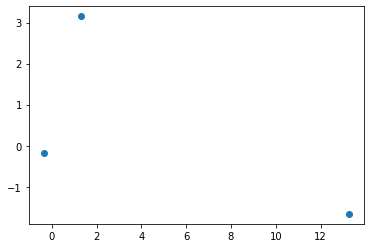

In [16]:
# Affichage des positions des centres de classes
plt.figure()
centroids = kmeans.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.show()

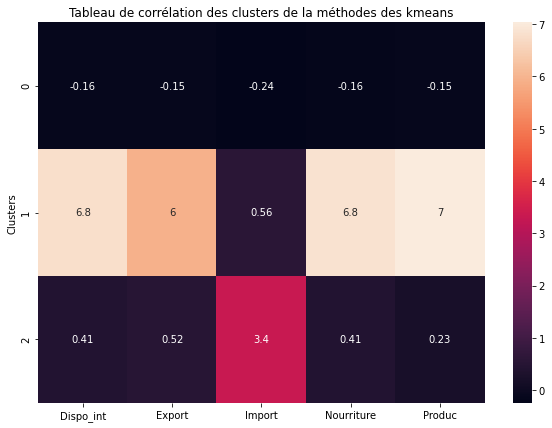

In [17]:
# Normalisation et groupe par les clusters 
f = data_norm.groupby(["Clusters"]).mean()
plt.figure(figsize=(10,7))
sns.heatmap(f, annot = True)
plt.title("Tableau de corrélation des clusters de la méthodes des kmeans")
plt.show()

Nous pouvons voir ici que se serait dans le cluster 1 que se trouverait les données les plus corrélée. Néanmois dans notre analyse, l'import de marchandise serait la donnée qui serait la plus suceptible d'être utiliser. 
Nous allons donc nous concentrer sur le Clusters 2 qui semblerait répertorier les pays les plus corrélés avec l'import de marchandises. 

In [18]:
# Nous selectionnons ici le cluster 2 puis préparons les données pour ajouter la population pour pousser l'analyse.
pays_suceptible = data_norm[data_norm["Clusters"]== 2]
b = pays_suceptible.reset_index()
data_pop = data_clus.set_index("Zone")
del data_pop["Valeur"]
a = data_pop.reset_index()
pays = a.merge(b, how= "right").drop_duplicates()
pays["Ratio"] = pays["Population"] / pays["Import"]
pays = pays.sort_values(by="Ratio",ascending=False)
pays

,Zone,Population,Dispo_int,Export,Import,Nourriture,Produc,Clusters,Ratio
37,France,"64,842.51",0.41,0.87,2.25,0.39,0.42,2,"28,859.88"
66,Mexique,"124,777.32",1.63,-0.21,4.75,1.60,1.03,2,"26,243.80"
0,Afrique du Sud,"57,009.76",0.66,-0.09,2.29,0.65,0.39,2,"24,896.66"
56,Japon,"127,502.73",0.80,-0.20,5.28,0.80,0.61,2,"24,164.06"
10,Allemagne,"82,658.41",0.49,1.18,4.05,0.45,0.33,2,"20,384.51"
46,Iraq,"37,552.78",-0.05,-0.23,2.05,-0.04,-0.25,2,"18,291.01"
85,Royaume-Uni de Grande-Bretagne et d'Irlande du...,"66,727.46",0.71,0.56,3.72,0.70,0.45,2,"17,957.13"
19,Arabie saoudite,"33,101.18",0.35,-0.20,3.41,0.37,-0.04,2,"9,709.39"
76,Pays-Bas,"17,021.35",-0.14,2.87,2.80,-0.14,0.16,2,"6,088.38"
94,Émirats arabes unis,"9,487.20",-0.12,-0.02,1.85,-0.11,-0.27,2,"5,117.26"


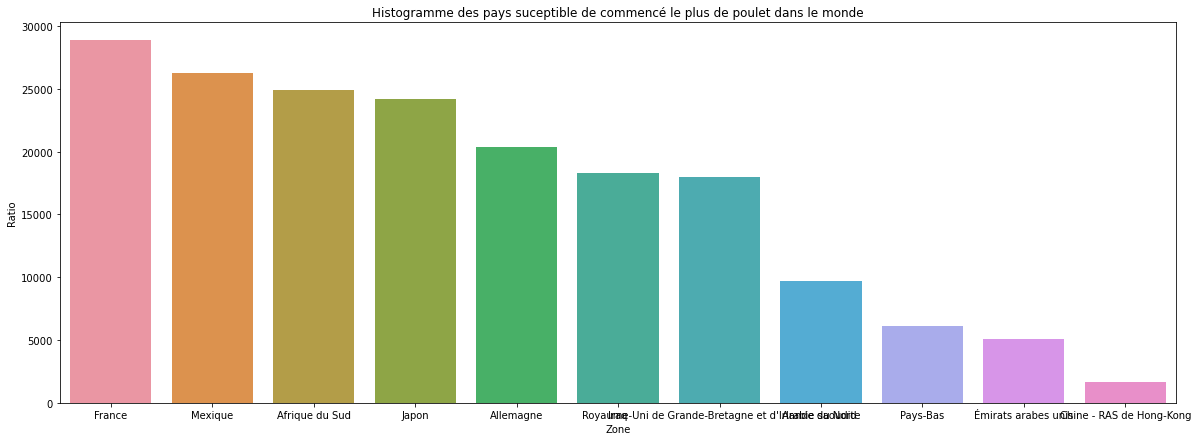

In [19]:
plt.figure(figsize= (20,7))
plt.title("Histogramme des pays suceptible de commencé le plus de poulet dans le monde")
sns.barplot(x= "Zone", y = "Ratio", data= pays) 
plt.show()